# NLP with spaCy

Although NLTK lets you do pretty much anything NLP-related, it can sometimes be difficult to parse through all of the different ways that you might approach a specific task. Enter spaCy, a more recent and more user-friendly NLP library, which has become increasingly widespread, particularly for certain core NLP tasks such as part-of-speech (POS) tagging and named-entitiy recognition (NER). We'll be using both NLTK and spaCy during this course, as do most people, since each have their strengths and weaknesses. 

One thing to know (and like!) about spaCy is that it relies on machine learning models trained on large amounts of carefully-labeled text. (This is in contrast to the "large language models" that we began the course by talking about, which "learn" language features in other ways.) The English-language spaCy model that we’re going to use in this lesson was trained on an annotated corpus called “OntoNotes”: 2 million+ words drawn from “news, broadcast, talk shows, weblogs, usenet newsgroups, and conversational telephone speech,” which were meticulously tagged by a group of researchers and professionals for people’s names and places, for nouns and verbs, for subjects and objects, and much more. 

Another thing to know (but maybe not like?!) about spaCY is that, like a lot of other major machine learning projects, OntoNotes was sponsored by the Defense Advaced Research Projects Agency (DARPA), the branch of the Defense Department that develops technology for the U.S. military. So, in short, it's complicated! 

In any case, let's get started.

### Loading the language model 

I've already downloaded and installed both spaCy and its English-language model (`en_core_web_sm`) on our JupyterHub. This is the model that was trained on the annotated “OntoNotes” corpus. 

To load it, we need to do the following

In [ ]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

### Processing a document

To get started with spaCy, we first need to process our document with the loaded NLP model. As with sentiment analysis, most of the heavy lifting is done in this single line of code--and not by us, thankfully!

After processing, the document object will contain tons of juicy language data — named entities, sentence boundaries, parts of speech — and the rest of our work will be devoted to accessing this information.

Let's create a `Document` object with a few sentences from the Universal Declaration of Human Rights:

In [ ]:
doc = nlp("""All human beings are born free and equal in dignity and rights. 
They are endowed with reason and conscience and should act towards one another in 
a spirit of brotherhood. Everyone has the right to life, liberty and security of person.""")

## What can we do with spaCy?

### Sentences

spaCy offers an easy way to identify sentences with its `.sents` method. `doc.sents` will turn the doc into a list of sentences. Once you've created a document object, you can iterate over the sentences it contains using the `.sents` attribute as follows:

In [ ]:
print("Here is the doc: ")
print(doc)
print("\n")
print("And here are the doc's sentences: ")

for sent in doc.sents:
    print(sent.text)

Nerdy Python note: The `.sents` attribute is a [generator](https://wiki.python.org/moin/Generators), so you can't index or count it directly. Generator functions are also known as "lazy iterators," which are objects that you can loop over like a list, but do not store their contents in memory. This may seem like a bug right now, but it's actually a feature because it's a way of saving memory when you're dealing with large amounts of text.

To index or count the .sents attribute, you'll need to convert it to a list first using the `list()` function. Then you can treat it like a list and access individual items:

In [ ]:
sentences_as_list = list(doc.sents)

In [ ]:
# check the length to make sure it worked

print("Here's the number of sentences: " + str(len(sentences_as_list)))

### Words

Iterating over a document (or a sentence) yields each word in turn. Words are represented with spaCy [Token](https://spacy.io/docs/api/token) objects, which have several interesting attributes. 

The `.text` attribute gives the word, and the `.lemma_` attribute gives the word's "lemma." What is a "lemma"?

Here are Daniel Jurafsky and James H. Martin on the subject:

> **Lemmas and Senses**
>
> Let’s start by looking at how one word (we’ll choose "mouse") might be defined in a dictionary:
>
> mouse (N)
> 1.  any of numerous small rodents...
> 2.  a hand-operated device that controls a cursor...
>
> Here the form "mouse" is the `lemma`, which is also called the "citation form." The form "mouse" would also be the lemma for the word "mice." One way to think about it is that dictionaries don’t have separated definitions for inflected forms like mice. 
>
>Similarly, "sing" is the lemma for "sing," "sang," and "sung." In many languages, the infinitive form is used as the lemma for the verb, so Spanish dormir “to sleep” is the lemma for duermes “you sleep”. The specific forms _sung_ or _carpets_ or _sing_ or _duermes_ are called `wordforms`."

Let's see how the words and lemmas compare in our tiny document:

In [ ]:
print("Word, lemma\n")
for word in doc:
    print(word.text + ", " + word.lemma_)
    
# Note: On the underscore at the end of a variable, see
# https://www.datacamp.com/community/tutorials/role-underscore-python#STU

As indicated above, we can also interate through the document by sentence. To wit:

In [ ]:
sentence = list(doc.sents)[1]  # same as sentence = sentences_as_list[1]

for word in sentence:
    print(word.text, word.lemma_)

Why does this distinction between "word" and "lemma" matter? Well for one, at certain times you might want to be able to gather all of the wordforms of a single word together so that you could count them as a single unit. This will come into play as we start counting words in various ways... 

But first: 

### How to load data from a file into spaCy

You can load data from a file easily with spaCy, which is good because most of the text we'll be analyzing in this course will come to us in file form.

In [ ]:
# get the text of the 2020 Democratic platform from GitHub 
import requests 

resp = requests.get('https://raw.githubusercontent.com/laurenfklein/QTM340-Fall22/main/corpora/platforms/democrat_platform_2020.txt')
dem_platform = resp.text


Next, let's turn the text into a spaCy document, as we did before:

In [ ]:
dem_plat_doc = nlp(dem_platform)

...and do the same thing for the 2020 Republican platform:

In [ ]:
resp = requests.get('https://raw.githubusercontent.com/laurenfklein/QTM340-Fall22/main/corpora/platforms/republican_platform_2020.txt')
repub_platform = resp.text

repub_plat_doc = nlp(repub_platform)

## Counting keywords (with custom code)

We'll learn other ways to do this later in the semester, but since this will help us on the way to figuring out why named entity recognition is useful, let's think about a scenario in which we want to know how many times President Biden was named in the Democratic platform vs. the Republican platform, we could do something like this:

In [ ]:
# define a basic function to count words

def count_words(keyword, document): # this says: we'll always pass in a keyword to search for  
                                    # and a spacy document to search 
    # here's our keyword hit counter
    key_count = 0
    
    # iterate through all the words in the document  
    for word in document:
        cur_word = word.text # remember, word is an object so you need to look at word.text
        
        # see if the keyword matches the word, and if so, increment our counter;
        if keyword.lower() == cur_word.lower(): # note that this is just a basic string comparison
            
            # if there's a match, increment the keyword counter by 1 
            key_count += 1
    
    # this returns the final keyword count
    return key_count

In [ ]:
# now call our newly defined function for the dem_plat_doc and the repic_plat_doc

num_d_bidens = count_words("Biden", dem_plat_doc)
num_r_bidens = count_words("Biden", repub_plat_doc)

print("Number of Biden mentions in Democratic platform: " + str(num_d_bidens))
print("Number of Biden mentions in Republican platform: " + str(num_r_bidens))

What if we wanted to see which people were named in each platform, but we didn't know how to search for them by name? This is where NER comes in. 

## Named Entity Recognition

Identifying sentences and words is just the beginning of what spaCy can do. Also encoded in the spaCy `document` is a great deal of information about named entities: that is, about people, places, and many types of things. This is what's known as "Named Entity Recognition," or NER.

You might use NER to identify the geographic locations mentioned in texts, a first step toward mapping them. Or you might use NER to identify the most frequently appearing characters in a novel, or to build a network of characters that appear together. Or you might use NER in a more exploratory capacity, as in the scenario I've outlined above.  

Below is a Named Entities chart taken from [spaCy's website](https://spacy.io/api/annotation#named-entities), which shows the different named entities that spaCy can identify, as well as their corresponding "type labels."

Note that "PERSON"--what we're going to look for in a sec--is just one of many different named entities that spaCy can recognize. 

Let's try it out. 

|Type Label|Description|
|:---:|:---:|
|PERSON|People, including fictional.|
|NORP|Nationalities or religious or political groups.|
|FAC|Buildings, airports, highways, bridges, etc.|
|ORG|Companies, agencies, institutions, etc.|
|GPE|Countries, cities, states.|
|LOC|Non-GPE locations, mountain ranges, bodies of water.|
|PRODUCT|Objects, vehicles, foods, etc. (Not services.)|
|EVENT|Named hurricanes, battles, wars, sports events, etc.|
|WORK_OF_ART|Titles of books, songs, etc.|
|LAW|Named documents made into laws.|
|LANGUAGE|Any named language.|
|DATE|Absolute or relative dates or periods.|
|TIME|Times smaller than a day.|
|PERCENT|Percentage, including ”%“.|
|MONEY|Monetary values, including unit.|
|QUANTITY|Measurements, as of weight or distance.|
|ORDINAL|“first”, “second”, etc.|
|CARDINAL|Numerals that do not fall under another type.|

Here's how we pull out all of the people mentioned in the Democratic platform using the `ents` method (short for "entitites":

In [ ]:
# an empty list we'll use to store the people
people = []
    
# iterate through all the words in the document (note this could also be sentences) 
for ent in dem_plat_doc.ents: # this is a method that turns the doc into entitites
    if ent.label_ == "PERSON": # again, here's basic string comparison
        if ent.text not in people: # we'll only add new people
            people.append(ent.text)
            
people

**Can you modify the code above to pull out the people named in the Republican platform?**

In [ ]:
## Remove below

# here's an empty list we can use to store the people
people = []
    
# Iterate through all the words in the document  
for ent in repub_plat_doc.ents: # this is a method that turns the doc into entitites
    if ent.label_ == "PERSON":
        if ent.text not in people: # only add new people
            people.append(ent.text)
            
people

**Python Bonus! Looking at the syntax of the function above, can you write a function that will pull out the people in any document?**

## Visualizing spaCy NER with displaCy

Here's a neat thing! To quickly see spaCy's NER in action, we can use the [spaCy module `displacy`](https://spacy.io/usage/visualizers#ent) with the `style=` parameter set to "ent" to see how spaCy tags its documents. (DisplaCy is special spaCy module for visualization).

To do so, we’re going to need to import displaCy, Also, because the `spaCy` code expects all strings to be unicode strings, per above, we can also include `from __future__ import unicode_literals` to make our lives easier.

In [ ]:
from __future__ import unicode_literals
from spacy import displacy
from collections import Counter
import pandas as pd
pd.options.display.max_rows = 600
pd.options.display.max_colwidth = 400

In [ ]:
displacy.render(dem_plat_doc, style="ent", jupyter=True)

Pretty neat, huh? Except, it's not completely perfect...

**Can you find some examples of things it tagged properly?**

**What about examples of things it misidentified?**

(You can scroll through the introductory material if you need to). 

This is a good reminder than spaCy is far from perfect and you always need to check how it does!

This is all we're going to do with NER today. As you can see this is just the very tip of the iceberg. You could now easily get, say, a full list of persons or orgs or products from any text. Feel free to explore further on your own.

## Dictionaries

One other basic way to analyze text is through what's known as a dictionary. (Not a Python dictionary!). This is just a set of words that evoke some category, optionally paired with a rating on some scale. As I mentioned last class, this is how the first methods of sentiment analysis worked--by counting up the number of "positive" and "negative" words that matched two predetermined sets of words--or dictionaries to produce the sentiment score. 

Even though there are now fancier ways to categorize langugage, dictionaries are still widely used--and to sometimes profound effect, as we saw in the "Birth Stories" paper.

The words that constitute a dictionary are determined according to a wide range of methods, from completely hand-crafted, to semi-supervised, to fully "learned" (by computers).

Let's look at a simple example. 

Here we'll define our own "immigration" dictionary by picking some words that we think have to do with the topic of immigration. (On the scale of hand-crafted to learned, this one is *extremely* hand-crafted). 

In [ ]:
immigration_dictionary=set(["wall", "border", "borders", "immigrants","immigration"])

We can actully use our previously defined `count_words` function to search both party platforms for how they stack up against the immigration dictionary:

In [ ]:
dem_counts = 0
repub_counts = 0

for word in immigration_dictionary:
    dem_counts += count_words(word, dem_plat_doc)
    repub_counts += count_words(word, repub_plat_doc)
    
print("Immigratation scores:")
print("Dems: " + str(dem_counts))
print("Repubs: " + str(repub_counts))

Interesting! For our (flimsy) definition of immmigration, the Democratic platform seem to have mentioned it more than the Republican platform at a ratio of nearly 2:1. 

# Part-of-Speech Tagging

I've left part-of-speech (PoS) tagging until last because it's simultaneously very useful, very complicated (unless you're a big grammar nerd), and very boring (again, unless you're a big grammar nerd). 

Why should we bother? Well, for one, parts of speech are the grammatical units of language — such as (in English) nouns, verbs, adjectives, adverbs, pronouns, and prepositions. Each of these parts of speech plays a different role in a sentence. By computationally identifying parts of speech, we can start computationally exploring syntax, the relationship between words — rather than only focusing on words in isolation.

I've attempted to make this lesson more exciting by including some dymanically-generated brightly colored charts and some [xkcd](https://xkcd.com/1443/). Buckle up!

<img src="https://imgs.xkcd.com/comics/language_nerd.png" >


## Part-of-Speech Tagging with spaCy 

In spaCy, POS tagging works much likes NER tagging. Here is a chart (which resembles the NER chart) of which parts of speech spaCy is able to recognize and identify:

| POS   | Description               | Examples                                      |
|:-----:|:-------------------------:|:---------------------------------------------:|
| ADJ   | adjective                 | big, old, green, incomprehensible, first      |
| ADP   | adposition                | in, to, during                                |
| ADV   | adverb                    | very, tomorrow, down, where, there            |
| AUX   | auxiliary                 | is, has (done), will (do), should (do)        |
| CONJ  | conjunction               | and, or, but                                  |
| CCONJ | coordinating conjunction  | and, or, but                                  |
| DET   | determiner                | a, an, the                                    |
| INTJ  | interjection              | psst, ouch, bravo, hello                      |
| NOUN  | noun                      | girl, cat, tree, air, beauty                  |
| NUM   | numeral                   | 1, 2017, one, seventy-seven, IV, MMXIV        |
| PART  | particle                  | ’s, not,                                      |
| PRON  | pronoun                   | I, you, he, she, myself, themselves, somebody |
| PROPN | proper noun               | Mary, John, London, NATO, HBO                 |
| PUNCT | punctuation               | ., (, ), ?                                    |
| SCONJ | subordinating conjunction | if, while, that                               |
| SYM   | symbol                    | $, %, §, ©, +, −, ×, ÷, =, :), 😝             |
| VERB  | verb                      | run, runs, running, eat, ate, eating          |
| X     | other                     | sfpksdpsxmsa                                  |
| SPACE | space                     |                                               |

You can access the POS for any word using the `pos_` attribute. If you want a more specific designation, you can use the `tag_` attribute.

Note that this *is* slightly different than accessing NER tags, which requires that you start with the document's entities (`document.ents`) rather than the document itself. There are technical reasons for this that I can explain if you're curious.

### Enough talk. Let's see POS tagging in action!

Let's look at the parts-of-speech in the Republican party platform.

In [ ]:
print("Word, POS, tag\n")

for word in repub_plat_doc:
    print(word.text, word.pos_, word.tag_)

### Extracting words by part of speech

Now we can write simple code to extract and recombine words by their part of speech. The following code creates two lists, one for all the nouns and another for all of the adjectives in the Republican platform:

In [ ]:
nouns = []
adjectives = []

for word in repub_plat_doc:
    if word.pos_ == 'NOUN' and word.text not in nouns:
        nouns.append(word.text)
    elif word.pos_ == 'ADJ' and word.text not in adjectives:
        adjectives.append(word.text)

print("here are the first 20 nouns: " + str(nouns[0:19]))
print("and here are the first 20 adjectives: " + str(adjectives[0:19]))

And below, some code to print out random pairings of an adjective from the text with a noun from the text:

In [ ]:
import random
print(random.choice(adjectives) + " " + random.choice(nouns))
print(random.choice(adjectives) + " " + random.choice(nouns))
print(random.choice(adjectives) + " " + random.choice(nouns))
print(random.choice(adjectives) + " " + random.choice(nouns))

### **Excercise #1**

Remember from a few cells up above how the `.tag_` attribute allows us to be even more specific thtan the `.pos` attribute about the parts of speech we want? 

How would we iterate through the words included in the Republican platform to get a list of only verbs in the past participle?

*Hint: you'll find the name of the tag you're looking for [here](https://spacy.io/api/annotation#pos-tagging). Click on "English" to expand.*

In [ ]:
# your code here 

## Larger syntactic units

So we can get individual words by their part of speech. Great! But what if we want larger chunks, based on their syntactic role in the sentence? The easy way is `.noun_chunks`, which is an attribute of a document or a sentence that evaluates to a list of [spans](https://spacy.io/docs/api/span) of noun phrases, regardless of their position in the document:

In [ ]:
for item in dem_plat_doc.noun_chunks:
    print(item.text)

For anything more sophisticated than this, though, we'll need to learn about how spaCy parses sentences into its syntactic components.

### Understanding dependency grammars

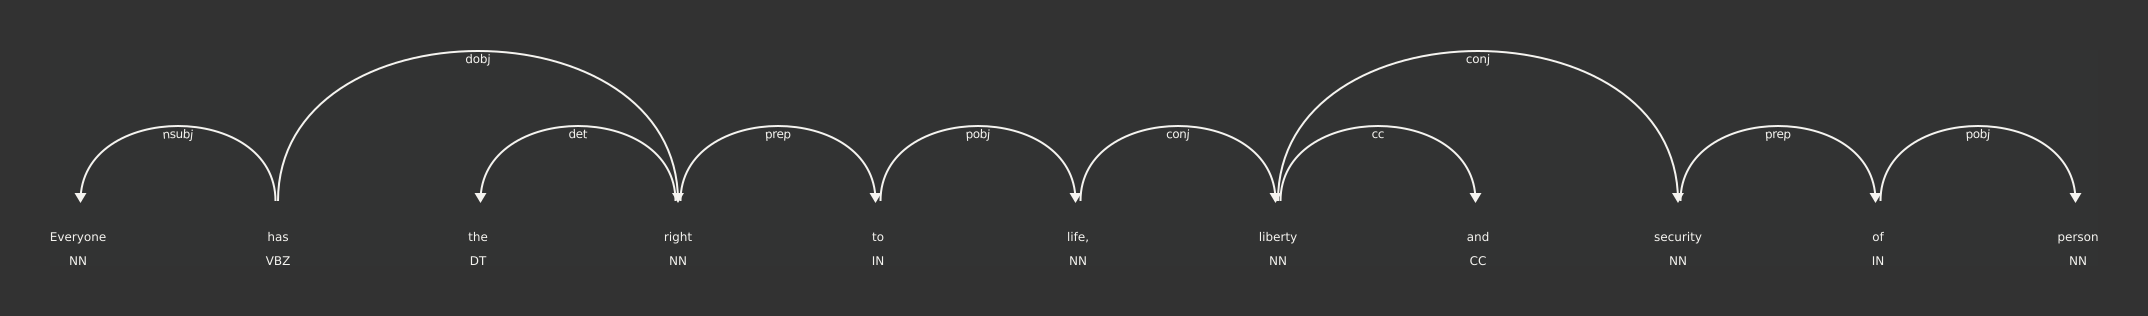

The idea of a dependency grammar is that every word in a sentence is a "dependent" on some other word, which is that word's "head." Those "head" words are in turn dependents of other words. The finite verb in the sentence is the ultimate "head" of the sentence, and is not itself dependent on any other word. (The dependents of a particular head are sometimes called its "children.")

The question of how to know what constitutes a "head" and a "dependent" is complicated. As a starting point, here's a passage from [Dependency Grammar and Dependency Parsing](http://stp.lingfil.uu.se/~nivre/docs/05133.pdf):

> Here are some of the criteria that have been proposed for identifying a syntactic relation between a head H and a dependent D in a construction C (Zwicky, 1985; Hudson, 1990):
>
> 1. H determines the syntactic category of C and can often replace C.
> 2. H determines the semantic category of C; D gives semantic specification.
> 3. H is obligatory; D may be optional.
> 4. H selects D and determines whether D is obligatory or optional.
> 5. The form of D depends on H (agreement or government).
> 6. The linear position of D is specified with reference to H."

There are different *types* of relationships between heads and dependents, and each type of relation has its own name. 

**Visit [the displaCy visualizer](https://demos.explosion.ai/displacy/?text=Everyone%20has%20the%20right%20to%20life%2C%20liberty%20and%20security%20of%20person&model=en&cpu=1&cph=0) to see how a particular sentence is parsed, and what the relations between the heads and dependents are.**

Here's a list of a few dependency relations and what they mean. ([A more complete list can be found here.](http://www.mathcs.emory.edu/~choi/doc/clear-dependency-2012.pdf))

* `nsubj`: this word's head is a verb, and this word is itself the subject of the verb
* `nsubjpass`: same as above, but for subjects in sentences in the passive voice
* `dobj`: this word's head is a verb, and this word is itself the direct object of the verb
* `iobj`: same as above, but indirect object
* `aux`: this word's head is a verb, and this word is an "auxiliary" verb (like "have", "will", "be")
* `attr`: this word's head is a copula (like "to be"), and this is the description attributed to the subject of the sentence (e.g., in "This product is a global brand", `brand` is dependent on `is` with the `attr` dependency relation)
* `det`: this word's head is a noun, and this word is a determiner of that noun (like "the," "this," etc.)
* `amod`: this word's head is a noun, and this word is an adjective describing that noun
* `prep`: this word is a preposition that modifies its head
* `pobj`: this word is a dependent (object) of a preposition

In [ ]:
# Let's take a look at how this works in practice
# We'll go back to using our first doc, the Universal Declaration of Human Rights, for the rest of this notebook

# Let's load it in again in case you're doing this part of the notebook as part of your homework
doc = nlp("All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood. Everyone has the right to life, liberty and security of person.")

for word in list(doc.sents)[2]:
    print("Word:", word.text)
    print("Tag:", word.tag_)
    print("Head:", word.head.text)
    print("Dependency relation:", word.dep_)
    print("Children:", list(word.children))
    print("")

We can also quickly see spaCy's POS tagging in action by we using the displacy on doc2 with the style= parameter set to "dep" (short for dependency parsing):

In [ ]:
# reimport all our stuff in case you're running this notebook as homework 
from __future__ import unicode_literals
from spacy import displacy
from collections import Counter
import pandas as pd
pd.options.display.max_rows = 600
pd.options.display.max_colwidth = 400

#Set some display options for the visualizer
options = {"compact": True, "distance": 90, "color": "yellow", "bg": "black", "font": "Gill Sans"}

displacy.render(doc, style="dep", jupyter=True, options=options)

### Using .subtree for extracting syntactic units

Now that the above makes perfect sense (or your eyes are glazing over), let's learn how the `.subtree` attribute evaluates to a generator (remember that?!) that can be flatted by passing it to `list()`. 

In this case, the subtree is a list of the word's syntactic dependents--essentially, the clause that the word belongs to.

This function merges a subtree and returns a string with the text of the words contained in it:

In [ ]:
def flatten_subtree(st):
       return ''.join([w.text_with_ws for w in list(st)]).strip() # just take my word for it!

With this function in our toolbox, we can write a loop that prints out the subtree for each word in a sentence:

In [ ]:
for word in list(doc.sents)[2]:
    print("Word:", word.text)
    print("Flattened subtree: ", flatten_subtree(word.subtree))
    print("")

Using the subtree and our knowledge of dependency relation types, we can write code that extracts larger syntactic units based on their relationship with the rest of the sentence. For example, to get all of the noun phrases that are subjects of a verb:

In [ ]:
subjects = []
for word in doc:
    if word.dep_ in ('nsubj', 'nsubjpass'):
        subjects.append(flatten_subtree(word.subtree))

In [ ]:
subjects

Or every prepositional phrase:

In [ ]:
prep_phrases = []
for word in doc:
    if word.dep_ == 'prep':
        prep_phrases.append(flatten_subtree(word.subtree))

In [ ]:
prep_phrases

###**Exercise #2** 

Modifying the code above, can you pull out the all of the predicate phrases in the 2020 Democratic Party Platform? 

In [ ]:
# your code here!

### Putting the Pieces Together ###

In "Connotation Frames of Power and Agency in Modern Films" and also in "Birth Stories," we saw how the combination of a particular part of speech--in those cases, verbs--combined with a lexcon (a slightly more content-ful dictionary) can be very illuminating. 

Now we're going to see what we can learn about the verbs in each party's platform--in particular, the "power" verbs that indicate power over the person/place/thing that the verb is doing something to.  

Reall that we've already learned how to 1) create a list of words that match a specific part of speech in a particular document; 2) lemmatize a particular word so that it is reduced to its root word; and 3) call a function that counts the number of words in a string that match a list of words in a (linguistic) dictionary. 

Now we're going to put the pieces together. 

In [ ]:
## This code cell creates a list of "power" verbs that we'll use a little later

# read in list of "power" verbs
resp = requests.get('https://raw.githubusercontent.com/laurenfklein/QTM340-Fall22/main/corpora/platforms/power-verbs.txt')
power_verbs = resp.text

# convert the verbs to a spacy object
power_verbs = nlp(power_verbs)

# then we're going to convert it to a list for easy comparisons, 
# and in the process lemmatize the verbs for easy comparison
power_list = []

for verb in power_verbs:
  if "\n" not in verb.text:  
    power_list.append(verb.lemma_)

# now you've got your list of power verbs to work with
# we'll just print out the lenght of the list so you
# get a sense of the numbers

len(power_list)


In [ ]:
# This code is very similar to code that you saw above. This is how we 
# pull out all of the unique verbs in each of the documents:

rep_verbs = []
dem_verbs = []

for word in repub_plat_doc:
    if word.pos_ == 'VERB':
        rep_verbs.append(word.text)

for word in dem_plat_doc:
    if word.pos_ == 'VERB':
        dem_verbs.append(word.text)

print("Number of unique rep verbs: " + str(len(rep_verbs)))
print("Number of unique dem verbs: " + str(len(dem_verbs)))

But if we're going to compare these verbs to a list, we need to lemmatize them first to make sure that we're able to match the one to the other. Which brings us to...

### **Exercise 3** 

Using the code cell above as a guide, write some code such that instead of creating lists of all the unique *verbs* in each platform, we're creating lists of the unique verb *lemmas* in those platforms  

In [ ]:
rep_verb_lemmas = []
dem_verb_lemmas = []

# your code goes here!



Now that we've got our lemmas, we can use a basic counting function to count the number of power verbs used in each platform:





In [ ]:
dem_count = 0
rep_count = 0

for verb in rep_verb_lemmas:
  if verb in power_list:
      rep_count += 1

for verb in dem_verb_lemmas:
  if verb in power_list:
      dem_count += 1
    
print("Number of power verbs:")
print("Dems: " + str(dem_count))
print("Repubs: " + str(rep_count))

print("\nPercentage of power verbs:")
print("Dems: " + str(dem_count / len(dem_verb_lemmas)))
print("Repubs: " + str(rep_count / len(rep_verb_lemmas)))


And one last exercise!

### **Exercise #4**

In a sentence, what is one thing we can conclude about the power verbs used in the Democratic Party Platform vs. the Republican one?

In [ ]:
# your answer here 


## Further reading and resources

[A few example programs can be found here.](https://github.com/aparrish/rwet-examples/tree/master/spacy)

We've barely scratched the surface of what it's possible to do with spaCy. [There's a great page of tutorials on the official site](https://spacy.io/docs/usage/tutorials) that you should check out!

*I wrote version 1.0 of this notebook based off materials by Alison Parrish. Dan Sinykin supplemented the 2020 version with material from Melanie Walsh's chapters [Named Entity Recognition](https://melaniewalsh.github.io/Intro-Cultural-Analytics/features/Text-Analysis/Named-Entity-Recognition.html) and [Part-of-Speech Tagging](https://melaniewalsh.github.io/Intro-Cultural-Analytics/features/Text-Analysis/POS-Keywords.html). For 2021, I've added material adapted from David Bamman's [Applied NLP](https://github.com/dbamman/anlp21) course, and revised the notebook again for 2022.*